# Spliting channels

In [1]:
from wfield import *
import tifffile
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import re
import shutil

In [2]:
data_folder = r'/datajoint-data/data/aeltona/Experiments/Sensory_Preconditioning/AA_ROS-1688_2024_01_27_sess000EAEIO/AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO/'
# tif_file_path = pjoin(data_folder, 'scan9FN2ANVG_Oddball_AA_ROS-1706_2025_MMStack_Default.ome.tif')
tif_files = [f for f in os.listdir(data_folder) if f.endswith('.tif')]
# localdisk = r'C:\datatemp'
localdisk = data_folder



In [3]:
tif_data_list = []
for tif_file in sorted(tif_files):
    tif_file_path = os.path.join(data_folder, tif_file)
    tif_data = tifffile.imread(tif_file_path);
    tif_data_list.append(tif_data)

concatenated_data = np.concatenate(tif_data_list, axis=0)
print(concatenated_data.shape)

<tifffile.TiffFile 'scan000EAEIO_AA…_Default.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan000EAEIO_AA…_Default.ome.tif'> MMStack series is missing files. Returning subset (4510, 1, 1, 1) of (18000, 1, 1, 1)
<tifffile.TiffFile 'scan000EAEIO_AA…efault_1.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan000EAEIO_AA…efault_1.ome.tif'> MMStack series is missing files. Returning subset (1584, 1, 1, 1) of (18000, 1, 1, 1)


(6094, 647, 730)


In [4]:
# Splitting into violet and green channels
violet_channel = concatenated_data[::2]  # Every second frame starting from the first
green_channel = concatenated_data[1::2]  # Every second frame starting from the second

# Ensure both channels have the same length (in case the number of frames is odd)
if violet_channel.shape[0] > green_channel.shape[0]:
    violet_channel = violet_channel[:-1]

In [6]:
h, w = green_channel.shape[1:]
# print(h,w)
merged_data = np.stack((violet_channel, green_channel), axis=1)
n_frames = merged_data.shape[0]
print(n_frames)


3047


In [33]:
filename_parts = re.split(r'_|\.', tif_files[0])
# Extract relevant information from the filename parts
scan_info = '_'.join(filename_parts[0:4])  # Joining parts 1 to 4 with underscores
frame_shape = f"{h}_{w}"

# Define the filename
filename = f"{scan_info}_{frame_shape}_2_uint16.dat"
filename

'scan000EAEIO_AA_ROS-1688_2024_647_730_2_uint16.dat'

In [34]:
# Define the full path for saving the file
save_path = os.path.join(data_folder, filename)

# Save the merged data as a binary file
merged_data.astype(np.uint16).tofile(save_path)
del merged_data

# Motion Correction

In [8]:
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
tif_file_path = os.path.join(data_folder, tif_files[0])
tif_preview = tifffile.imread(tif_file_path)
_,h,w = tif_preview.shape



<tifffile.TiffFile 'scan000EAEIO_AA…_Default.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan000EAEIO_AA…_Default.ome.tif'> MMStack series is missing files. Returning subset (4510, 1, 1, 1) of (18000, 1, 1, 1)


In [36]:
# print(h,w)

In [37]:
# open file with read/write 

dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))




In [38]:
dat.shape

(3047, 2, 647, 730)

In [39]:
green_channel.shape

(3047, 647, 730)

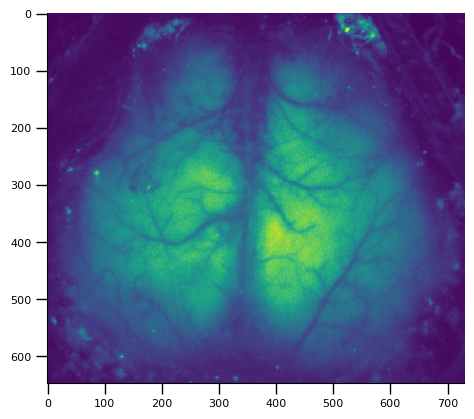

In [40]:
plt.imshow(dat[0,0,:,:])

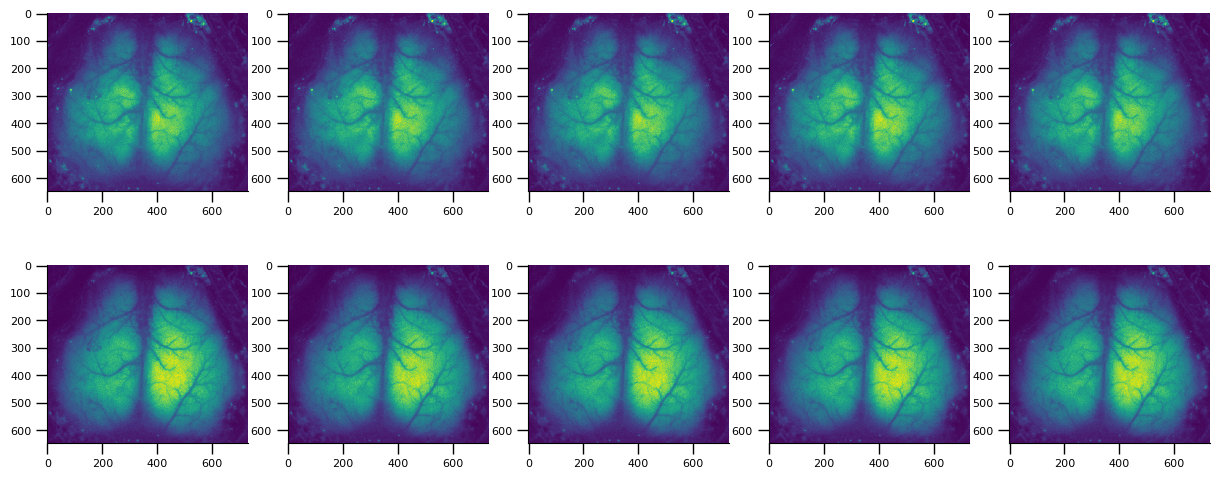

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

num_frames = 5;
for j in range(num_frames):
    axes[0, j].imshow(dat[j, 0, :, :])  # Violet channel, First 5 frames
    axes[1, j].imshow(dat[j, 1, :, :])  # Blue channel, First 5 frames

plt.show()

In [42]:
(yshifts,xshifts),rot = motion_correct(dat,chunksize=512,
                                     apply_shifts=True)
del dat # close and finish writing


Motion correction: 100%|██████████| 6/6 [01:22<00:00, 13.83s/it]


In [43]:

# save the shifts
shifts = np.rec.array([yshifts,xshifts],dtype=[('y','float32'),('x','float32')])
np.save(pjoin(localdisk,'motion_correction_shifts.npy'),shifts)
# np.save(pjoin(data_folder,'motion_correction_shifts.npy'),shifts)

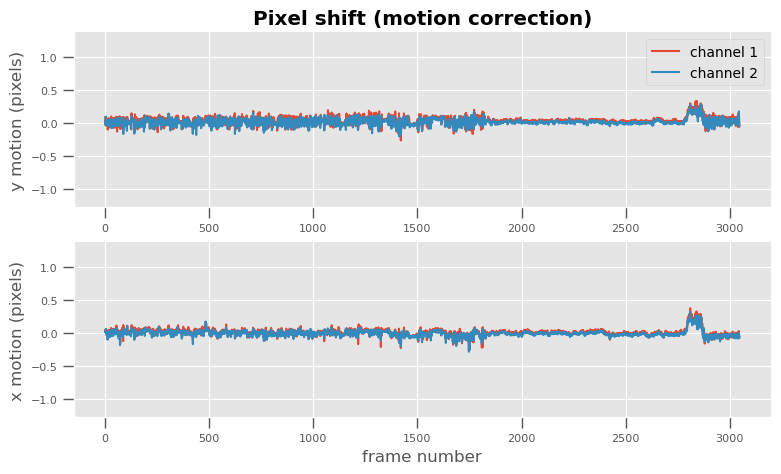

In [44]:
import pylab as plt
plt.matplotlib.style.use('ggplot')

%matplotlib inline

# localdisk = '/mnt/dual/temp_folder/CSP23_20200226' # this should be an SSD or a fast drive

shifts = np.load(pjoin(localdisk,'motion_correction_shifts.npy'))

plot_summary_motion_correction(shifts,localdisk);

In [7]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.resources import INLINE


In [8]:
dat[:, 1].shape

(8619, 600, 600)

In [10]:
# Initialize Bokeh for notebook output
output_notebook(INLINE)

# Define the dimensions of the video frames
num_frames, channels, height, width = dat.shape
# Create a Bokeh figure
p = figure(x_range=(0, width), y_range=(0, height))

v_chn = 0
g_chn = 1
# Create an image RGBA plot
p.image_rgba(image=[dat[:, g_chn]], x=0, y=0, dw=width, dh=height)

# Show the Bokeh plot
show(p)

: 

: 

# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

The first example subtracts the average from each frame (i.e. the array in `frames_average` with 3 dimensions (ch,w,h)). The average can be the mean of all frames or only those in the baseline period of the experiment.


In [10]:
# dat = mmap_dat(dat_path)
dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))

try:
    frames_average = np.load(pjoin(localdisk,'frames_average.npy')) # or see below (can also be computed using the baseline)
    print("Frames Average found!")
except Exception as e:
    print("Error:", e)
    print("Averaging frames...")
    chunkidx = chunk_indices(len(dat),chunksize=512)
    frame_averages = []
    for on,off in tqdm(chunkidx):
       frame_averages.append(dat[on:off].mean(axis=0))
    frames_average = np.stack(frame_averages).mean(axis = 0)
    np.save(pjoin(localdisk,'frames_average.npy'),frames_average)
    print(f"frames_average.npy saved in {localdisk}")


Error: [Errno 2] No such file or directory: '/datajoint-data/data/aeltona/Experiments/Sensory_Preconditioning/AA_ROS-1688_2024_01_27_sess000EAEIO/AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO/frames_average.npy'
Averaging frames...


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

frames_average.npy saved in /datajoint-data/data/aeltona/Experiments/Sensory_Preconditioning/AA_ROS-1688_2024_01_27_sess000EAEIO/AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO/


In [11]:
U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'U.npy'),U)
np.save(pjoin(localdisk,'SVT.npy'),SVT)

Computing SVT from the raw data: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


# Hemodynamics Correction

In [12]:
U = np.load(pjoin(localdisk,'U.npy'))
SVT = np.load(pjoin(localdisk,'SVT.npy'))
# SVT.shape

In [15]:
fs = 5

output_folder = localdisk
frame_rate = 10.

tstart = time.time()

SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT[:,1::2],axis=1,
                    fill_value='extrapolate')(t[0::2])
SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
                                             SVT_470, 
                                             SVT_405, 
                                             fs=fs,
                                             freq_lowpass=2)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))

np.save(pjoin(localdisk,'rcoeffs.npy'),rcoeffs)
np.save(pjoin(localdisk,'T.npy'),T)
np.save(pjoin(localdisk,'SVTcorr.npy'),SVTcorr)



Done hemodynamic correction in 30.915637969970703 s 


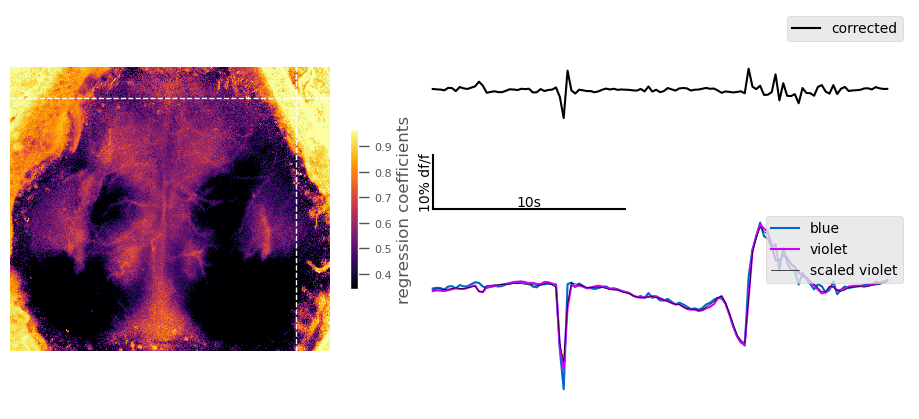

In [16]:
try: # don't crash while plotting
    import pylab as plt
    plt.matplotlib.style.use('ggplot')
    from wfield import  plot_summary_hemodynamics_dual_colors
    plot_summary_hemodynamics_dual_colors(rcoeffs,
                                            SVT_470,
                                            SVT_405,
                                            U,
                                            T,
                                            frame_rate=frame_rate,
                                            duration = 12,
                                            outputdir = output_folder);
except Exception as err:
    print('There was an issue plotting.')
    print(err)